Formation OpenClassrooms DS-IML - **Marc Lefèvre**, <marc.lefevre@noos.fr>

# **Projet 5 : Catégorisation de questions Stack Overflow**

## **2ème partie : LDA - Approches non supervisées et mixtes**

Dans cette seconde partie, nous allons travailler autour du procédé appelé **Latent Dirichlet Allocation** (LDA).<br><br>Nous verrons si son utilisation en tant qu'outils **d'extraction de thèmes** pourrait constituer une approche **100% non-supervisée** satisfaisante dans le cadre de notre projet.<br><br>Nous verrons ensuite quels résultats la **LDA**, prise cette fois comme procédé de **feature engineering** ou de **réduction dimensionnelle**, nous permet d'ontenir.

## **Opérations préliminaires**

### **Importation des bibliothèques python utiles**

In [37]:
import pandas as pd
import pickle
import spacy
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import xgboost as xgb
import nltk

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import f1_score, classification_report, multilabel_confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV, cross_val_predict, cross_validate, cross_val_score, learning_curve

from time import time

from scipy import sparse

from bayes_opt import BayesianOptimization

from skmultilearn.problem_transform import BinaryRelevance

from nltk.stem.snowball import SnowballStemmer

# Ignorance de certains avertissements
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

### **Echantillonage Train/Test**

In [7]:
feat = pickle.load(open("Data/X.pickle", "rb"))
targ = pickle.load(open("Data/y.pickle", "rb"))

In [8]:
feat_train = feat[:20000]
feat_test = feat[20000:]

targ_train = targ[:20000]
targ_test = targ[20000:]

### **Chargement de SpaCy**

In [24]:
nlp = spacy.load("en")

# On enlève le caractère "#" de la liste des suffixes afin que le tokenizer spacy
# ne s'en serve pas pour diviser un monogramme
suffixes = list(nlp.Defaults.suffixes)
suffixes.remove("#")
suffix_regex = spacy.util.compile_suffix_regex(suffixes)
nlp.tokenizer.suffix_search = suffix_regex.search

### **Paramètre LDA**

In [ ]:
NB_SUJETS = 25

### **Définitions de fonctions utiles :**

### **Outils de nettoyage du corpus**

**Fonction de nettoyage**

In [26]:
def clean_text(texte):
    
    char_gardes = r'[^a-z#+.\s]'
    return re.sub(char_gardes, '', texte) 

**Fonction de suppression des stopwords / verbes renvoyant les données sous forme de texte ou "bag-of-words"**

In [27]:
def remove_sw(texte, return_verbs, return_token):
    
    doc = nlp(texte)
    
    if return_verbs :
    
        tokens = [token for token in doc if \
                  token.is_stop == False and token.is_punct == False\
                  and token.is_space == False
                 ]
    
    else :
        
        tokens = [token for token in doc if \
                  token.is_stop == False and token.is_punct == False\
                  and token.pos_ != "VERB"\
                  and token.is_space == False
                 ]
    
    if return_token :
        
        return tokens
    
    txt = ""
    
    for t in tokens :
        
        txt = txt + " " + t.text
        txt = txt.lstrip()
        
    return txt

**Pipeline de nettoyage**

In [28]:
# Fonction "pipeline" regroupant les deux fonctions précédentes.
def pipe_clsw(texte, return_verbs = True, return_token = True):
    """
    Nettoye et enlève les SW d'un text/str et retourne une liste de tokens.
    Par défaut : 
    - On garde les verbe. Si False on les élimine du résultat.
    - On retourne une liste de token. Si False on retourne une str des tokens.
    """
    
    res = remove_sw(clean_text(texte), return_verbs, return_token)
    
    return res

### **Démonstration de ces outils**

In [29]:
# texte original
feat_train[250]

"flutter animated container i have a raisedbutton widget and an animatedcontainer widget in a screen, and the idea is that upon pressing the raisedbutton the width of the animatedcontainer would then decrease in a given duration. the documentation of the animatedcontainer states that all i would need to do is declare the width of the widget as a variable, and then setstate(() {}) after changing the value and it will automatically change to that value during the duration. i have tried to implement this and upon pressing the raisedbutton the variables value definitely changes (based on printing the value of it after pressing it), however the widget's width does not change with it. am i missing something obvious? my widgets are within a container in a pageview and my code for the raisedbutton and animatedcontainer is as follows: here is my widget tree:"

In [31]:
# filtrage SW sous forme "tokenisée"...
res = pipe_clsw(feat_train[250])
print(res)

[flutter, animated, container, raisedbutton, widget, animatedcontainer, widget, screen, idea, pressing, raisedbutton, width, animatedcontainer, decrease, given, duration, documentation, animatedcontainer, states, need, declare, width, widget, variable, setstate, changing, value, automatically, change, value, duration, tried, implement, pressing, raisedbutton, variables, value, definitely, changes, based, printing, value, pressing, widgets, width, change, missing, obvious, widgets, container, pageview, code, raisedbutton, animatedcontainer, follows, widget, tree]


In [32]:
# filtrage SW et formes verbales sous forme de texte...
res = pipe_clsw(feat_train[250], False, False)
res

'flutter container raisedbutton widget animatedcontainer widget screen idea raisedbutton width animatedcontainer duration documentation animatedcontainer width widget variable setstate value automatically value duration raisedbutton variables value definitely changes value widgets width obvious widgets container pageview code raisedbutton animatedcontainer widget tree'

# **1-) Approches LDA non-supervisées**

## **A) LDA avec CountVectorizer**

Nous allons utiliser la **LDA** (Latent Dirichlet Allocation) sur notre corpus de texte en vue d'en extraire des thèmes, et voir si ce procéder est utilisable au vu de notre objectif.<br>Dans ce but il nous faut d'abord nettoyer nos données puis les vectoriser.<br>Nous utiliserons une vectorisation sur la fréquence des termes avec **CountVectorizer**.

### **Filtrage SW et verbes**

Dans le cadre de notre approche **d'extraction thématique** par **LDA** nous estimons que ni les **stop words** ni les **formes verbales** ne sont des éléments pertinents à garder dans notre corpus. Nous utilisons nos fonctions en conséquence.

In [34]:
now = time()
feat_train_clean_nv = [pipe_clsw(t, False, False) for t in feat_train]
feat_test_clean_nv = [pipe_clsw(t, False, False) for t in feat_test]
print(f"Ce travail de nettoyage a pris {time() - now:.0f} secondes.")

Ce travail de nettoyage a pris 418 secondes.


In [35]:
pickle_out = open("Data/feat_train_clean_nv.pickle", "wb")
pickle.dump(feat_train_clean_nv, pickle_out)
pickle_out.close()

pickle_out = open("Data/feat_test_clean_nv.pickle", "wb")
pickle.dump(feat_test_clean_nv, pickle_out)
pickle_out.close()

### **Vectorisation avec CountVectorizer**

Procédons à la vectorisation **term frequency** avec **CountVectiruzer**.<br>Le tokenizer utilisé par CountVectorizer va opérer des séparations indésirables dans notre cas. On utilise donc à la place un tokenizer "neutre" qui ne fonctionnera qu'avec les "espaces" et préservera des expressions importantes que nous souhaitons garder.

In [2]:
feat_train_clean_nv = pickle.load(open("Data/feat_train_clean_nv.pickle", "rb"))

In [3]:
# bypass du tokenizer natif (cas "node.js"...) et remplacement par un tokenizer "neutre"
def neutral_tokenizer(tokens):
    
    return tokens.split(" ")

tf_vect = CountVectorizer(max_df = 0.50, min_df = 10, tokenizer = neutral_tokenizer)
tf_vect.fit(feat_train_clean_nv)

CountVectorizer(max_df=0.5, min_df=10,
                tokenizer=<function neutral_tokenizer at 0x000000000EC20B80>)

In [4]:
feat_train_clean_nv_vect = tf_vect.transform(feat_train_clean_nv)
feat_train_clean_nv_vect.shape

(20000, 3514)

### **Utilisation de la LDA**

In [8]:
lda_tf = LatentDirichletAllocation(n_components = NB_SUJETS, 
                                max_iter = 5,
                                learning_method = "online",
                                learning_offset = 50., 
                                random_state = 47)

In [40]:
start = time()
lda_tf.fit(feat_train_clean_nv_vect)
print(f"L'entrainement de la LDA a mis : {time() - start:.0f} secondes.")

L'entrainement de la LDA a mis : 23 secondes.


**Fonctions utiles à l'exploitation de la LDA.**

In [41]:
# Fonction affichant les "n" termes les plus représentatifs des thèmes trouvés par la LDA.
def montrer_sujets(model, feature_names, n) :
    
    for sujet_idx, sujet in enumerate(model.components_):
        print(f"topic numéro {sujet_idx} :")
        print(" ".join(feature_names[i] for i in sujet.argsort()[: -n -1:-1]))
        print("----------------------------------")

# Fonction retournant le terme le plus représentatif de chaque thème trouvé par LDA.        
def retourne_tags(model, feature_names) :
    
    liste = []
    
    for sujet_idx, sujet in enumerate(model.components_):
        # print(f"topic numéro {sujet_idx} :")
        
        liste.append(feature_names[sujet.argmax()])
        
    return liste

Thèmes extraits représentés par leurs termes les plus représentatifs :

In [42]:
montrer_sujets(lda_tf, tf_vect.get_feature_names(), 10)

topic numéro 0 :
key model password ubuntu invalid tensorflow item certificate default ssl
----------------------------------
topic numéro 1 :
android app error project studio build nt gradle ios xcode
----------------------------------
topic numéro 2 :
java class typescript project error d library code package jar
----------------------------------
topic numéro 3 :
server error request docker service nt response http container connection
----------------------------------
topic numéro 4 :
table column data values number columns row dataframe + value
----------------------------------
topic numéro 5 :
angular input html form component nt field css value code
----------------------------------
topic numéro 6 :
button spring text bootstrap event script application jquery boot code
----------------------------------
topic numéro 7 :
react multiple state api inside component true like native classes
----------------------------------
topic numéro 8 :
error code type function database nt la

**Critique :**<br>La pertinence des thèmes extraits, illustrés par leurs listes de mots les plus représentatifs, semble inégale. On en identifie parfaitement certains, beaucoup moins d'autres. Toute fois, la qualité pourrait probablement être améliorée en jouant sur les paramètres des outils utilisés pour arriver à ce résultat.

Extraction de la liste des meilleurs mots pouvant servir de tags...

In [43]:
liste_tags_lda_tf = retourne_tags(lda_tf, tf_vect.get_feature_names())
print(liste_tags_lda_tf)

['key', 'android', 'java', 'server', 'table', 'angular', 'button', 'react', 'error', 'list', 'version', 'string', 'python', 'div', 'google', 'image', 'variable', 'user', 'object', 'page', 'git', 'test', 'windows', 'file', 'function']


**Critique :**<br>Si certains termes pourraient parfaitement constituer de bons tags ('python, java, etc...), ce n'est pas le cas d'autres, plus vagues ou génériques (user, error, file, etc.).<br><br>Néanmoins, continuons notre démarche...

**Modélisation de notre corpus par LDA**

In [44]:
topic_score_tf = lda_tf.transform(feat_train_clean_nv_vect)

# sauvegarde
pickle_out = open("Data/topic_score_tf.pickle", "wb")
pickle.dump(topic_score_tf, pickle_out)
pickle_out.close()

topic_score_tf.shape

(20000, 25)

Nous pouvons extraire les topics principaux attribués à chaque question...

In [45]:
topic_predicted_tf = np.argmax(topic_score_tf, axis = 1)
topic_predicted_tf

array([22,  9,  8, ...,  7, 11, 10], dtype=int64)

...et au passage observer leur distribution.

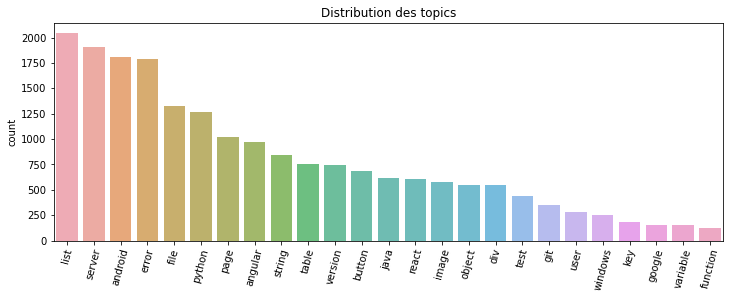

In [46]:
topics_predits = pd.Series([liste_tags_lda_tf[n] for n in topic_predicted_tf])

fig = plt.figure(figsize = (12, 4))
sns.countplot(topics_predits, 
              alpha = 0.8, 
              order = topics_predits.value_counts().index)
plt.xticks(rotation = 75)
plt.title("Distribution des topics")

plt.show()

### **Comparaison *tags originaux* vs *tags LDA***

In [47]:
print(liste_tags_lda_tf)

['key', 'android', 'java', 'server', 'table', 'angular', 'button', 'react', 'error', 'list', 'version', 'string', 'python', 'div', 'google', 'image', 'variable', 'user', 'object', 'page', 'git', 'test', 'windows', 'file', 'function']


In [48]:
vect_y = CountVectorizer(tokenizer = neutral_tokenizer).fit(targ_train)
liste_tags_reels = vect_y.get_feature_names()
print(liste_tags_reels)

['android', 'angular', 'asp.net', 'c#', 'css', 'docker', 'flutter', 'google', 'html', 'ios', 'java', 'javascript', 'jquery', 'laravel', 'misc', 'node.js', 'pandas', 'php', 'python', 'react', 'spring', 'sql', 'swift', 'typescript', 'visual']


Eléments communs :

In [49]:
common = list(set(liste_tags_lda_tf).intersection(liste_tags_reels))
print(common, len(common))

['angular', 'python', 'react', 'java', 'android', 'google'] 6


**Critique :**<br>Il n'y a que 6 tags en commun, cette démarche est caduque.

### **Nombre de tags par question**

Par ailleurs, avec ce procédé se poserait aussi la question des tags multiples. Comment, à partir d'une LDA, assigner plusieurs tags à une question ?<br><br>La façon de faire la plus pertinente serait d'utiliser une logique de seuil en fonction des **topic scores** des questions. On peut donc regarder s'il y a un rapport éventuel entre le nombre de tags à prévoir pour chaque question et les **topic score** prédits par le modèle.

In [50]:
# Liste du nombre de tags à prédire de y_train
len_y = []

for s in targ_train :
    len_y.append(len(s.split()))
    
len_y[:10]

[1, 2, 1, 1, 1, 1, 1, 2, 1, 1]

Regardons à quels **topic score** correspondent les n-ièmes tags cibles pour chaque question (pour les 10 premières questions...)

In [51]:
seuils_topic_score = []

for i, n in zip(topic_score_tf[:10], len_y[:10]) :
    ar = np.sort(i)
    print(ar[-n])   

0.46646252558849827
0.22611822660618838
0.5684443910404374
0.593549977635679
0.9244720413047791
0.4593838749670163
0.8484983494778513
0.3920191526857461
0.3749909382663318
0.39248949938541083


Regardons si ces valeurs pourrait se déduire d'une condition type "être au dessus d'un certain seuil"...

In [52]:
for i, n in zip(topic_score_tf[:10], len_y[:10]) :
    ar = np.sort(i)
    print(ar[-(n+1)])

0.19612684002950442
0.12292145867922938
0.26360323850186546
0.1276051390906421
0.04014334330809454
0.340415232053121
0.08073241974581613
0.06922566639085238
0.2655594147181958
0.3445441144352376


**Critique :**<br>Il semble impossible de définir un seuil de "topic score" à partir duquel tagger une question permettant de faire correspondre un nombre de tags issus du modèle LDA avec le nombre de tags cibles.

Notre ballon d'essai nous a permi d'émettre de sérieuses critiques sur notre démarche. Regardons toutefois si une approche avec une vectorisation **TfIdf** serait de nature à changer les chose...

## **B) - Approche LDA avec TF-IDF**

Voyons si une vectorisation TF-IDF nous permet d'obtenir mieux...

In [53]:
feat_train_clean_nv = pickle.load(open("Data/feat_train_clean_nv.pickle", "rb"))

Vectorisation...

In [54]:
idf_vect = TfidfVectorizer(max_df = 0.50, min_df = 10)

idf_vect.fit(feat_train_clean_nv)

TfidfVectorizer(max_df=0.5, min_df=10)

In [55]:
feat_train_clean_nv_idf = idf_vect.transform(feat_train_clean_nv)
feat_train_clean_nv_idf.shape

(20000, 3632)

LDA...

In [56]:
lda_idf = LatentDirichletAllocation(n_components = NB_SUJETS, 
                                max_iter = 5,
                                learning_method = "online",
                                learning_offset = 50., 
                                random_state = 47)

In [57]:
start = time()
lda_idf.fit(feat_train_clean_nv_idf)
print(f"L'entrainement de la LDA_idf a mis : {time() - start:.0f} secondes.")

L'entrainement de la LDA_idf a mis : 16 secondes.


Observation des "sujets extraits"...

In [58]:
montrer_sujets(lda_idf, idf_vect.get_feature_names(), 10)

topic numéro 0 :
android color xml button icon font background app navigation image
----------------------------------
topic numéro 1 :
dataframe pandas column columns spark df rows timestamp data index
----------------------------------
topic numéro 2 :
mongodb ruby sierra macos homebrew high intel pylint haxm wizard
----------------------------------
topic numéro 3 :
date format datetime time month day year timezone yyyymmdd atom
----------------------------------
topic numéro 4 :
dplyr factor filereader experiment levels integer byte multiple simple empty
----------------------------------
topic numéro 5 :
fragment tab tabs fragments activity tablayout orientation shadow nameerror jetpack
----------------------------------
topic numéro 6 :
python error command file pip php windows version directory module
----------------------------------
topic numéro 7 :
visual studio vs vscode code editor ctrl join netbeans shortcut
----------------------------------
topic numéro 8 :
xcode ios ap

Transformation...

In [59]:
topic_score_idf = lda_idf.transform(feat_train_clean_nv_idf)
topic_score_idf.shape

(20000, 25)

In [60]:
topic_predicted_idf = np.argmax(topic_score_idf, axis = 1)
topic_predicted_idf

array([18, 20, 18, ..., 18, 16,  6], dtype=int64)

In [61]:
topic_score_idf[150]

array([0.01033704, 0.01033704, 0.01033704, 0.01033704, 0.01033704,
       0.01033704, 0.01033704, 0.01033704, 0.01033704, 0.01033704,
       0.01033704, 0.01033704, 0.01033704, 0.01033704, 0.01033704,
       0.01033704, 0.10198767, 0.01033704, 0.03073076, 0.01033704,
       0.63986671, 0.01033704, 0.01033704, 0.01033704, 0.01033704])

Tags obtenus...

In [62]:
liste_tags_lda_idf = retourne_tags(lda_idf, idf_vect.get_feature_names())
print(liste_tags_lda_idf)

['android', 'dataframe', 'mongodb', 'date', 'dplyr', 'fragment', 'python', 'visual', 'xcode', 'airflow', 'numpy', 'ionic', 'git', 'net', 'swift', 'jupyter', 'div', 'nltk', 'code', 'modal', 'angular', 'android', 'flutter', 'npm', 'kubernetes']


In [63]:
print(liste_tags_reels)

['android', 'angular', 'asp.net', 'c#', 'css', 'docker', 'flutter', 'google', 'html', 'ios', 'java', 'javascript', 'jquery', 'laravel', 'misc', 'node.js', 'pandas', 'php', 'python', 'react', 'spring', 'sql', 'swift', 'typescript', 'visual']


Tags communs à la liste de labels...

In [64]:
common_idf = list(set(liste_tags_lda_idf).intersection(liste_tags_reels))
print(common_idf, len(common_idf))

['flutter', 'angular', 'python', 'android', 'swift', 'visual'] 6


L'approche **TfIdf** trouve le même nombre de tags communs.

regardons la distribution des thèmes prédits

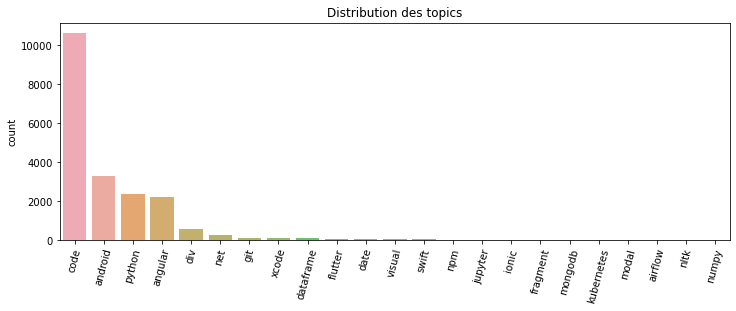

In [65]:
topics_predits_idf = pd.Series([liste_tags_lda_idf[n] for n in topic_predicted_idf])

fig = plt.figure(figsize = (12, 4))
sns.countplot(topics_predits_idf, 
              alpha = 0.8, 
              order = topics_predits_idf.value_counts().index)
plt.xticks(rotation = 75)
plt.title("Distribution des topics")

plt.show()

Et là nous tombons manifestement sur un problème.<br>Il s'avère qu'en fait, telle que nous l'avons utilisée, la vectorisation **Tf-Idf** n'est pas adaptée à l'utilisation de la **LDA**. La LDA est un modèle probabilistique qui fonctionne à partir de la fréquence des mots rencontrés. Dès lors, à partir du moment où nous l'avons faite travailler sur une matrice TF-IDF qui n'est pas constituée de nombres entiers correspondant à des fréquences, les résultats ont probablement été faussés.

Ressources supplémentaires :<br>https://datascience.stackexchange.com/questions/14676/scikit-learn-should-i-fit-model-with-tf-or-tf-idf

## **Conclusion sur l'approche LDA non-supervisée**

Au regard de notre projet, cette approche pourrait être pertinente si :<br>- 1) Les thèmes extraits par la LDA correspondaient bien au thèmes représentés par les tags cibles.<br>- 2) Si chaque thème avait pour terme le plus représentatifs le tag cible correspondant.<br>- 3) Si la modélisation LDA permettait en plus une assignation de tags multiples satisfaisantes au regard des tags cibles.

Or, nous ne voyons pas comment ces conditions pourraient être remplies. Surtout que faire l'hypothèse qu'elles puissent l'être revient à penser que le contenu de Stack Overflow aurait pu être généré par des robots...<br>En tentant cette approche nous attendions beaucoup trop de la LDA alors que nous sommes clairement dans une problématique nécessitant une approche **supervisée**.

# **2-) Approches LDA mixtes**

L'idée est maintenant d'utiliser la modélisation en **topic scores** obtenu par **LDA** pour des approches supervisées.

Exemple de donnée dans sa forme réduite à 25 dimensions par LDA :

In [66]:
topic_score_tf = pickle.load(open("Data/topic_score_tf.pickle", "rb"))
topic_score_tf[0]

array([0.00173913, 0.00173913, 0.0867469 , 0.00173913, 0.00173913,
       0.00173913, 0.00173913, 0.19612684, 0.00173913, 0.00173913,
       0.00173913, 0.00173913, 0.07575567, 0.00173913, 0.00173913,
       0.00173913, 0.00173913, 0.00173913, 0.00173913, 0.00173913,
       0.00173913, 0.00173913, 0.46646253, 0.00173913, 0.14012546])

In [67]:
topic_score_tf.shape

(20000, 25)

### **Conditions propres au projet**

Avant de continuer, précisons le cadre global dans lequel nous allons évoluer.

### **- Cadre de classification multilabels**

Etant donné que chaque question est susceptible d'avoir plus d'un tag, nous sommes dans un cadre de **classification multilabels**.

Nous allons utiliser des outils du module **scikit.ml**.

http://scikit.ml/

Notre approche va être celle de la **Binary Relevance** qui consiste à envisager une classification à **N labels** comme **N classifications** "normales" à un seul label. C'est adapté aux situations où il n'y a pas de relations entre labels.

Cela a un inconvénient majeur, à savoir que chaque modélisation "multilabels" revient à effectuer **25 classifications binaires**, ce qui va modifier notre façon d'opérer.

### **- Métrique utilisée**

La métrique que nous allons utiliser sera adaptée à notre cadre multilabels. Il s'agit du **F1-score weighted**.<br><br>Le **F1-Score** est au départ une métrique qui se focalise sur l'aptitude d'un modèle à prédire les "vrais positifs". Il est donc adapté lorsque les classes sont nombreuses ou inégalement réparties et que notre objectif est justement de prédire ces "vrais positifs".<br><br>Dans notre cadre **multilabel** de **binary relevance**, le **F1-Score weighted** sera la moyenne balancée des 25 "sous-modélisations" binaires qui composeront une modélisation.

### **- Validation croisée et hyper-paramétrage**

Etant données notre cadre, nous n'allons pas procéder par validation croisée comme il est usuel de le faire.<br><br>Pour ce qui est de l'hyper-paramétrage, nous ne procéderons pas non plus par **randomized search** ou **gridserach**. Nous utiliserons **l'optimisation bayésienne** (module **bayes_opt**) qui nous permettra d'hyper-paramétrer nos modèles, au moins en partie, pour un coût en ressources restreint.

## **A) Approche mixte LDA avec CountVectorizer**

Nos **features** vont être le tableau **topic_score_tf**, et notre **cible** une **forme vectorisée de nos tags cibles**.

In [81]:
# préparation des features train
std = StandardScaler().fit(topic_score_tf)

X_train_mxt = std.transform(topic_score_tf)

# préparation des features test
feat_test_clean_nv = [pipe_clsw(t, False, False) for t in feat_test]
feat_test_clean_vect = tf_vect.transform(feat_test_clean_nv)

X_test_mxt = lda_tf.transform(feat_test_clean_vect)
X_test_mxt = std.transform(X_test)

In [69]:
# préparation des cibles
def neutral_tokenizer(tokens):
    
    return tokens.split(" ")

vect_targ = CountVectorizer(tokenizer = neutral_tokenizer).fit(targ_train)

y_train = vect_targ.fit_transform(targ_train)
y_test = vect_targ.transform(targ_test)

In [70]:
# Création puis sauvegarde d'un éléments qui nous sera utile plus tard...
df_targ = pd.DataFrame(y_train.toarray(), columns = vect_targ.get_feature_names())
labels = df_targ.columns.tolist()

In [82]:
# sauvegarde
pickle_out = open("Data/X_train_mxt.pickle", "wb")
pickle.dump(X_train_mxt, pickle_out)
pickle_out.close()
# sauvegarde
pickle_out = open("Data/X_test_mxt.pickle", "wb")
pickle.dump(X_test_mxt, pickle_out)
pickle_out.close()
# sauvegarde
pickle_out = open("Data/y_train.pickle", "wb")
pickle.dump(y_train, pickle_out)
pickle_out.close()
# sauvegarde
pickle_out = open("Data/y_test.pickle", "wb")
pickle.dump(y_test, pickle_out)
pickle_out.close()
# sauvegarde
pickle_out = open("Data/df_targ.pickle", "wb")
pickle.dump(df_targ, pickle_out)
pickle_out.close()
# sauvegarde
pickle_out = open("Data/labels.pickle", "wb")
pickle.dump(labels, pickle_out)
pickle_out.close()

In [14]:
X_train_mxt = pickle.load(open("Data/X_train_mxt.pickle", "rb"))
y_train = pickle.load(open("Data/y_train.pickle", "rb"))
X_test_mxt = pickle.load(open("Data/X_test_mxt.pickle", "rb"))
y_test = pickle.load(open("Data/y_test.pickle", "rb"))

### **Baseline : prédicteur naif sur tag "misc"**

Le tag **misc** est le plus présent

Une telle prédiction aurait pour résultat un tableau de dimension **5555 x 25** peuplé de **0** sauf la colonne d'index **14** montrant elle des **1**.<br>Créons ce tableau et calculons sont **F1 Score Weighted**.

In [23]:
pred_baseline = np.zeros((5555, 25))
pred_baseline[:, vect_targ.get_feature_names().index("misc")] = 1

In [39]:
accuracy_score(y_test, pred_baseline)

0.1918991899189919

In [32]:
f1_score(y_test, 
         pred_baseline, 
         average = "weighted")

0.046752672038824154

### **Modélisations test - "out of the box"**

Testons quelques modélisations avec des réglages par défaut.

**Fonction utile**

In [60]:
def mc_modelize(model, X_train, y_train, X_test, y_test) :
    
    m_clas = BinaryRelevance(classifier = model)
    
    start = time()
    
    m_clas.fit(X_train, y_train)
    
    preds = m_clas.predict(X_test)
    
    acc = accuracy_score(y_test, preds)
    
    score = f1_score(y_test,
                     preds,
                     average = "weighted")
    
    temps = time() - start
    
    return score, temps

### **Régression Logistique**

In [61]:
rlc = LogisticRegression(random_state = 47)
score, temps = mc_modelize(rlc, X_train_mxt, y_train, X_test_mxt, y_test)
print(f"La modélisation a duré {temps:.02f} secondes pour un score de : {score:.03f}")

La modélisation a duré 1.03 secondes pour un score de : 0.284


### **RandomForest Classifier**

In [62]:
rf = RandomForestClassifier()
score, temps = mc_modelize(rf, X_train_mxt, y_train, X_test_mxt, y_test)
print(f"La modélisation a duré {temps:.02f} secondes pour un score de : {score:.03f}")

La modélisation a duré 93.44 secondes pour un score de : 0.313


### **XGBoost**

In [63]:
xgb_clas = xgb.XGBClassifier(objective = "reg:logistic", random_state = 47)
score, temps = mc_modelize(xgb_clas, X_train_mxt, y_train, X_test_mxt, y_test)
print(f"La modélisation a duré {temps:.02f} secondes pour un score de : {score:.03f}")

La modélisation a duré 21.70 secondes pour un score de : 0.329


**XGBoost** produit les meilleurs résultats de loin, nous allons poursuivre avec lui.

### **Hyper-paramétrage par optimisation bayésienne**

Afin d'économiser des ressources lors de ce projet, nous allons comme nous l'avons déjà dit procéder à des **hyper-paramétrages partiels** avec l'aide du module **baysian-optimization**.

**Utilisation du module Bayesian Optimization**

https://analyticsindiamag.com/implementing-bayesian-optimization-on-xgboost-a-beginners-guide/

https://github.com/fmfn/BayesianOptimization

https://github.com/fmfn/BayesianOptimization/blob/master/examples/basic-tour.ipynb

Il faut hyper-paramétrer le modèle sur l'ensemble des données. Essai avec BO pour éviter le random/gridsearch couteux en ressources.

In [107]:
def bo_tune_m_clas(max_depth, gamma, n_estimators ,learning_rate, eta):
    params = {'max_depth': int(max_depth),
              'gamma': gamma,
              'n_estimators': int(n_estimators),
              'learning_rate': learning_rate,
              'subsample': 0.8,
              'eta': eta, 
              'verbosity': 0, 
              'objective': "reg:logistic",
              'random_state' : 47#, 'eval_metric': 'f1'
             }
    
    # création du model qu'on va utiliser
    xgb_model = xgb.XGBClassifier(**params)
    # création du modèle multilabels
    m_clas = BinaryRelevance(classifier = xgb_model)
    
    m_clas.fit(X_train_mxt, y_train)
    preds = m_clas.predict(X_test_mxt)

    score = f1_score(y_test, preds, average = "weighted")

    return score

In [108]:
m_clas_bo = BayesianOptimization(bo_tune_m_clas, 
                                 {'max_depth': (3, 10),
                                  'gamma': (0, 1),
                                  'eta' : (0.01, 0.1),
                                  'learning_rate':(0, 1),
                                  'n_estimators':(50, 250)},
                                 random_state = 47)

In [109]:
start = time()
m_clas_bo.maximize(n_iter=10, init_points=5, acq='ucb')
print(f"L'optimisation a mis : {time() - start:.0f} secondes.")

|   iter    |  target   |    eta    |   gamma   | learni... | max_depth | n_esti... |
-------------------------------------------------------------------------------------
|  1        |  0.3068   |  0.02021  |  0.9745   |  0.7287   |  5.46     |  191.5    |
|  2        |  0.3202   |  0.08196  |  0.6456   |  0.4146   |  7.942    |  99.33    |
|  3        |  0.3614   |  0.03304  |  0.02401  |  0.09873  |  5.103    |  178.2    |
|  4        |  0.2859   |  0.039    |  0.1855   |  0.9172   |  4.896    |  104.7    |
|  5        |  0.2957   |  0.0959   |  0.1271   |  0.7473   |  3.037    |  221.4    |
|  6        |  0.3375   |  0.07494  |  0.831    |  0.2529   |  6.918    |  77.88    |
|  7        |  0.3394   |  0.04988  |  0.3877   |  0.3779   |  3.126    |  209.4    |
|  8        |  0.3788   |  0.05805  |  0.7509   |  0.02094  |  5.707    |  177.9    |
|  9        |  0.0      |  0.0904   |  1.0      |  0.0      |  7.073    |  176.3    |
|  10       |  0.0      |  0.05394  |  1.0      |  0.0

Récupération et arrondissement des meilleurs hyper-paramètres.

In [110]:
best_params_01 = m_clas_bo.max['params']
best_params_01

{'eta': 0.05804675564145853,
 'gamma': 0.7508746000467451,
 'learning_rate': 0.020936078328953722,
 'max_depth': 5.70746025818558,
 'n_estimators': 177.89849134874282}

In [111]:
best_params_01['max_depth']= int(best_params_01['max_depth'])
best_params_01['n_estimators']= int(best_params_01['n_estimators'])

Entrainement du modèle optimisé

In [112]:
xgb_model = xgb.XGBClassifier(objective = "reg:logistic", random_state = 47, **best_params_01)
# création du modèle multilabels
m_clas1 = BinaryRelevance(classifier = xgb_model)

In [115]:
start = time()
m_clas1.fit(X_train_mxt, y_train)
print(f"L'entrainement a pris {time() - start:.0f} secondes")

L'entrainement a pris 34 secondes


Score du modèle :

In [116]:
pred_01 = m_clas1.predict(X_test_mxt).toarray()
f1_score(y_test, 
         pred_01, 
         average = "weighted")

0.36388630357806884

## **B) Approche mixte LDA avec CountVectorizer sur texte normalisé**

Nous allons reproduire cette approche, mais cette fois sur un corpus de texte normalisé.

Concrêtement, pour ce qui est du traitement de nos textes, nous allons continuer de nous passer des formes verbales, mais en plus ceux-ci passeront par des étapes **lemmatisation** et de **stemming**.

In [161]:
# Rechargement du corpus
feat_train_clean_nv = pickle.load(open("Data/feat_train_clean_nv.pickle", "rb"))
feat_test_clean_nv = pickle.load(open("Data/feat_test_clean_nv.pickle", "rb"))

In [162]:
feat_train_clean_nv[0]

'script inside aws lambda function bash script inside lambda function aws docs code python nodejs java documents possible bash concrete evidence example'

**Lemmatisation**

La lemmatisation consiste à renvoyer si possible la forme canonique d'un mot. Voici un exemple, où pour une question issue de notre corpus nous imprimons chaque token et sa version "lemmatisée".

In [163]:
for w in nlp(feat_train_clean_nv[0]):
    print(w, " - ", w.lemma_)

script  -  script
inside  -  inside
aws  -  aws
lambda  -  lambda
function  -  function
bash  -  bash
script  -  script
inside  -  inside
lambda  -  lambda
function  -  function
aws  -  aws
docs  -  docs
code  -  code
python  -  python
nodejs  -  nodejs
java  -  java
documents  -  document
possible  -  possible
bash  -  bash
concrete  -  concrete
evidence  -  evidence
example  -  example


**Remarque :**<br>Manifestemment, puisque nous sommes en présence de nombreux termes techniques et que les formes verbales sont absentes, ce procédé pourrait n'avoir qu'une influence assez faible puisqu'il va peu modifier notre corpus. Mais nous allons quand même l'appliquer.

In [164]:
# fonction de lemmatisation
def lemmatize(model, corpus):
    
    corp_lemma = []
    
    for doc in corpus :
        
        corp_lemma.append([w.lemma_ for w in model(doc)])
        
    return corp_lemma

**Application de la lemmatisation**

In [165]:
start = time()
feat_train_lem = lemmatize(nlp, feat_train_clean_nv)
feat_test_lem = lemmatize(nlp, feat_test_clean_nv)
print(f"La lemmatisation a pris {time() - start:.0f} secondes.")

La lemmatisation a pris 219 secondes.


**Stemming**

Le **stemming** se définit comme une "désuffixation" des mots. Nous allons utiliser le stemmer **snowball** du module **nltk**.

In [166]:
stemmer = SnowballStemmer("english")

**Exemple :**<br>Stemming d'une question sous sa forme déjà lemmatisée.

In [167]:
for w in feat_train_lem[0][:10] :
    print(w, "   -  ", stemmer.stem(w))

script    -   script
inside    -   insid
aws    -   aw
lambda    -   lambda
function    -   function
bash    -   bash
script    -   script
inside    -   insid
lambda    -   lambda
function    -   function


Les actions accomplies sont plus visibles même si encore modestes dans notre exemple.

In [168]:
# fonction de stemming qui recrée également des "phrases" factices car la vectorization ne fonctionne
# pas sur des données bag-of-words...
def stemm(stemmer, corpus):
    
    corp_stem = []
    
    for doc in corpus :
        
        ligne = " ".join([stemmer.stem(w) for w in doc])
        corp_stem.append(ligne)
        
    return corp_stem

In [170]:
start = time()
feat_train = stemm(stemmer, feat_train_lem)
feat_test = stemm(stemmer, feat_test_lem)
print(f"Le stemming a pris {time() - start:.0f} secondes.")

Le stemming a pris 11 secondes.


### **Nouvelle LDA**

**Vectorisation CountVectorizer**

In [172]:
tf_vect2 = CountVectorizer(max_df = 0.50, min_df = 5)
tf_vect2.fit(feat_train)

feat_train_vect = tf_vect2.transform(feat_train)
feat_test_vect = tf_vect2.transform(feat_test)

In [173]:
# Sauvegarde
pickle_out = open("Data/feat_train_vect.pickle", "wb")
pickle.dump(feat_train_vect, pickle_out)
pickle_out.close()

pickle_out = open("Data/feat_test_vect.pickle", "wb")
pickle.dump(feat_test_vect, pickle_out)
pickle_out.close()

pickle_out = open("Data/tf_vect2.pickle", "wb")
pickle.dump(tf_vect2, pickle_out)
pickle_out.close()

**LDA**

In [174]:
lda_tf2 = LatentDirichletAllocation(n_components = nb_sujets, 
                                max_iter = 5,
                                learning_method = "online",
                                learning_offset = 50., 
                                random_state = 47)

In [175]:
start = time()
lda_tf2.fit(feat_train_vect)
print(f"L'entrainement de la LDA a mis : {time() - start:.0f} secondes.")

L'entrainement de la LDA a mis : 25 secondes.


Après la normalisation du corpus, les termes caractérisant les topics extraits sont un peu "spéciaux"...

In [176]:
montrer_sujets(lda_tf2, tf_vect2.get_feature_names(), 10)

topic numéro 0 :
set sort listview assert review pid dto signal iflutt circular
----------------------------------
topic numéro 1 :
symbol explor void nil markdown viewmodel dag internalmodulescjsloader webservic devtool
----------------------------------
topic numéro 2 :
json element option item differ point product recyclerview select ie
----------------------------------
topic numéro 3 :
page request api url app respons header servic error code
----------------------------------
topic numéro 4 :
variabl attribut googl font excel env selenium code nt chrome
----------------------------------
topic numéro 5 :
way nt time number like differ question function exampl instanc
----------------------------------
topic numéro 6 :
file imag line folder like code csv nt webpack path
----------------------------------
topic numéro 7 :
test properti import typescript warn ts export group type unit
----------------------------------
topic numéro 8 :
date visual studio start code format vs default

Maintenant le modèle entrainé, procédons à la modélisation...

In [177]:
topic_score_tf2 = lda_tf2.transform(feat_train_vect)

# sauvegarde
pickle_out = open("Data/topic_score_tf2.pickle", "wb")
pickle.dump(topic_score_tf2, pickle_out)
pickle_out.close()

#topic_score_tf2.shape

In [179]:
topic_score_tf2 = pickle.load(open("Data/topic_score_tf2.pickle", "rb"))

# préparation des features
std2 = StandardScaler()

X_train_mxt_n = std2.fit_transform(topic_score_tf2)

X_test_unscaled = lda_tf2.transform(feat_test_vect)
X_test_mxt_n = std2.transform(X_test_unscaled)

# chargement des targets
y_train = pickle.load(open("Data/y_train.pickle", "rb"))
y_test = pickle.load(open("Data/y_test.pickle", "rb"))

**Optimisation du modèle**

In [180]:
def bo_tune_m_clas2(max_depth, gamma, n_estimators ,learning_rate, eta):
    params = {'max_depth': int(max_depth),
              'gamma': gamma,
              'n_estimators': int(n_estimators),
              'learning_rate': learning_rate,
              'subsample': 0.8,
              'eta': eta, 
              'verbosity': 0, 
              'objective': "reg:logistic",
              'random_state' : 47#, 'eval_metric': 'f1'
             }
    
    # création du model qu'on va utiliser
    xgb_model = xgb.XGBClassifier(**params)
    # création du modèle multilabels
    m_clas = BinaryRelevance(classifier = xgb_model)
    
    m_clas.fit(X_train_mxt_n, y_train)
    preds = m_clas.predict(X_test_mxt_n)

    score = f1_score(y_test, preds, average = "weighted")

    return score

In [181]:
m_clas_bo2 = BayesianOptimization(bo_tune_m_clas2, {'max_depth': (2, 10),
                                                  'gamma': (0.01, 1),
                                                  'eta' : (0.01, 0.1),
                                                  'learning_rate':(0, 1),
                                                  'n_estimators':(50, 250)}, 
                                  random_state = 47)

In [182]:
start = time()
m_clas_bo2.maximize(n_iter=10, init_points=5, acq='ucb')
print(f"L'optimization a mis : {time() - start:.0f} secondes.")

|   iter    |  target   |    eta    |   gamma   | learni... | max_depth | n_esti... |
-------------------------------------------------------------------------------------
|  1        |  0.3841   |  0.02021  |  0.9747   |  0.7287   |  4.812    |  191.5    |
|  2        |  0.3913   |  0.08196  |  0.6491   |  0.4146   |  7.648    |  99.33    |
|  3        |  0.3758   |  0.03304  |  0.03377  |  0.09873  |  4.403    |  178.2    |
|  4        |  0.379    |  0.039    |  0.1936   |  0.9172   |  4.167    |  104.7    |
|  5        |  0.3909   |  0.0959   |  0.1358   |  0.7473   |  2.042    |  221.4    |
|  6        |  0.3786   |  0.07494  |  0.8327   |  0.2529   |  6.477    |  77.88    |
|  7        |  0.3775   |  0.04988  |  0.3939   |  0.3779   |  2.144    |  209.4    |
|  8        |  0.3802   |  0.07489  |  0.9714   |  0.9886   |  4.408    |  206.2    |
|  9        |  0.3838   |  0.04038  |  0.2185   |  0.8538   |  9.413    |  98.16    |
|  10       |  0.0      |  0.1      |  1.0      |  0.0

In [185]:
best_params_02 = m_clas_bo2.max['params']
best_params_02

{'eta': 0.08196441414940485,
 'gamma': 0.6491062359632096,
 'learning_rate': 0.41459960718816635,
 'max_depth': 7.648248090184073,
 'n_estimators': 99.32987635492839}

In [186]:
best_params_02['max_depth']= int(best_params_02['max_depth'])
best_params_02['n_estimators']= int(best_params_02['n_estimators'])

In [187]:
xgb_model_mxt_n = xgb.XGBClassifier(objective = "reg:logistic", random_state = 47, **best_params_02)
score, temps = mc_modelize(xgb_model_mxt_n, X_train_mxt_n, y_train, X_test_mxt_n, y_test)
print(f"La modélisation a duré {temps:.02f} secondes pour un score de : {score:.3f}")

La modélisation a duré 26.16 secondes pour un score de : 0.380


Ce dernier résultat est meilleur que le précédent. Même si nous sommes peut-être dans une **marge d'erreur** du à notre méthode d'optimisation assez partielle, les étapes de normalisation semblent nous avoir fait gagner **1,6 points** au **F1 Score Weighted**.

### **Learning Curve**

Voyons maintenant par curiosité si la **learning curve** de notre modèle laisse envisager une amélioration des résultats avec plus de données.

In [188]:
m_clas_mxt_n = BinaryRelevance(classifier = xgb_model_mxt_n)

l_sizes = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

size, score, val_score = learning_curve(m_clas_mxt_n, 
                                        X_train_mxt_n, 
                                        y_train,
                                        scoring = "f1_weighted",
                                        cv = 5,
                                        train_sizes = l_sizes,
                                        random_state = 47)

In [189]:
sc = val_score.mean(axis = 1)
std = val_score.std(axis = 1)
print(sc)

[0.36139752 0.36824808 0.36978123 0.37416356 0.37482923 0.37347967]


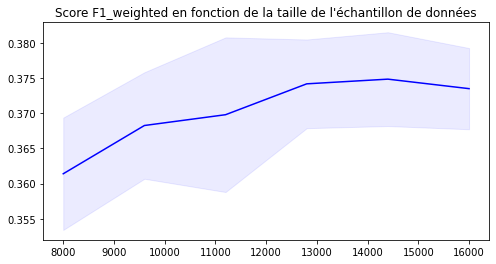

In [190]:
fig = plt.figure(figsize = (8, 4))
plt.plot(size, sc, color='blue')
plt.fill_between(size, 
                 sc - std,
                 sc + std, alpha=0.08,
                 color="blue")
plt.title("Score F1_weighted en fonction de la taille de l'échantillon de données")

plt.show()

La **learning curve** ne laisse pas apparaitre de perspective d'amélioration spectaculaire avec de l'ajout de données...

**Fin de la deuxième partie**